# ****<center> <span style="color: pink;">ATML PA_0 </span>****

### <span style="color: DeepPink;"> Name : Khadeeja Toseef </span>
### <span style="color: DeepPink;"> Roll Number : 27100309 </span>

## <center> <span style="color: pink;">Task 4: Training Variational Autoencoders </span>

### <span style="color: HotPink;"> 1. Train the VAE
</span>

<span style="color: MediumPurple;"> (a) Download the FashionMNIST dataset from torchvision.
</span>

<span style="color: #D8BFD8;">importing libraries </span>

In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

<span style="color: #D8BFD8;"> device setup
</span>

In [28]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


<span style="color: #D8BFD8;"> downloading dataset
</span>

In [29]:
# define transformation
transform = T.ToTensor()

# load dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./task4data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./task4data', train=False, download=True, transform=transform)

# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

<span style="color: MediumPurple;"> (b) Download the provided architecture.py file for VAE architecture.
</span>

In [30]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

<span style="color: MediumPurple;"> (c) Define your loss function composing of MSE Loss for reconstruction and KL divergence. Without modifying the model architecture, train the VAE on FashionMNIST.
</span>

<span style="color: #D8BFD8;"> computing loss
</span>

In [ ]:
def vae_loss(recon_x, x, mu, logvar): 
    # Reconstruction loss 
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') 
    # KL divergence 
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    return recon_loss + kl_div


<span style="color: #D8BFD8;"> training loop
</span>

Epoch [1/10], Train Loss: 31.5715, Val Loss: 26.6215


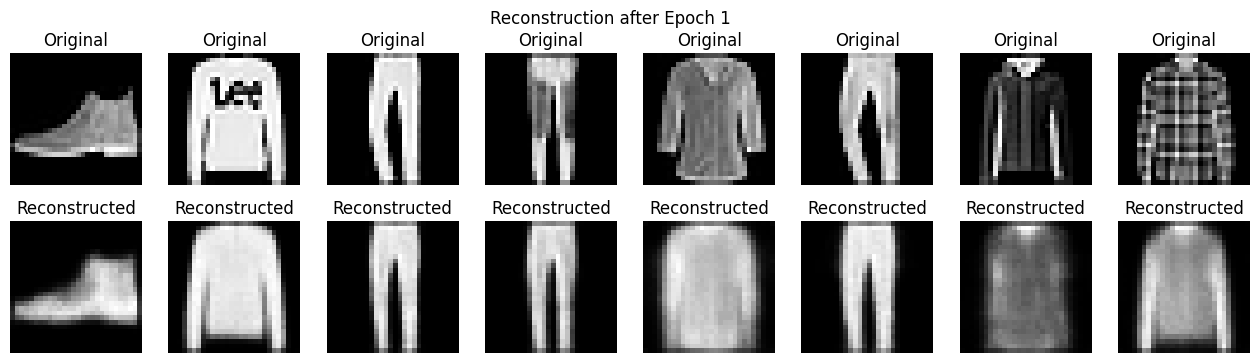

Epoch [2/10], Train Loss: 25.7869, Val Loss: 25.2007


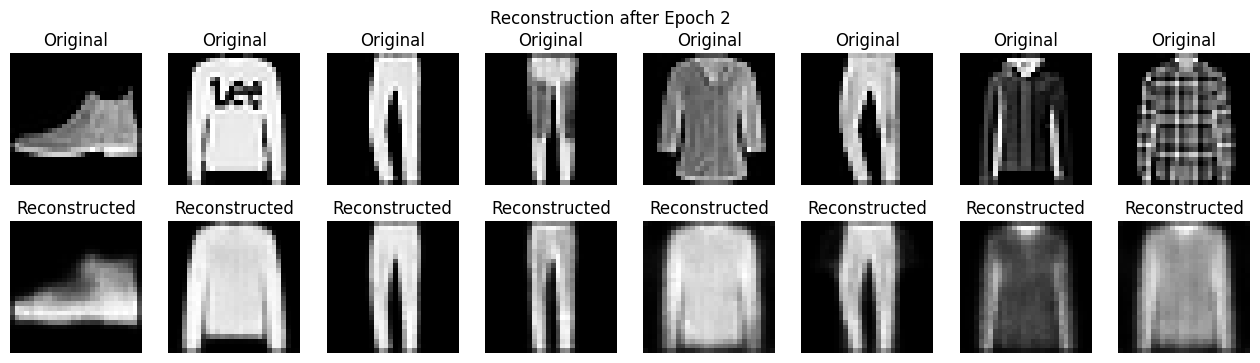

Epoch [3/10], Train Loss: 24.8732, Val Loss: 24.6219


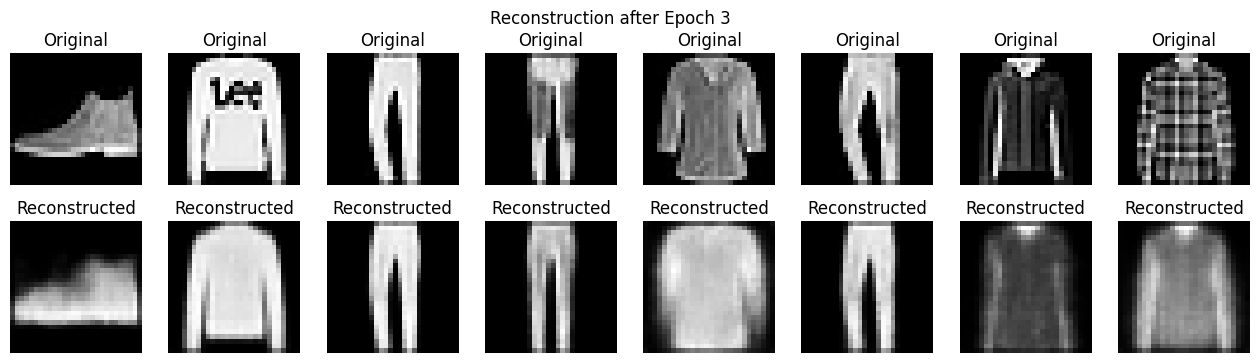

Epoch [4/10], Train Loss: 24.4259, Val Loss: 24.3770


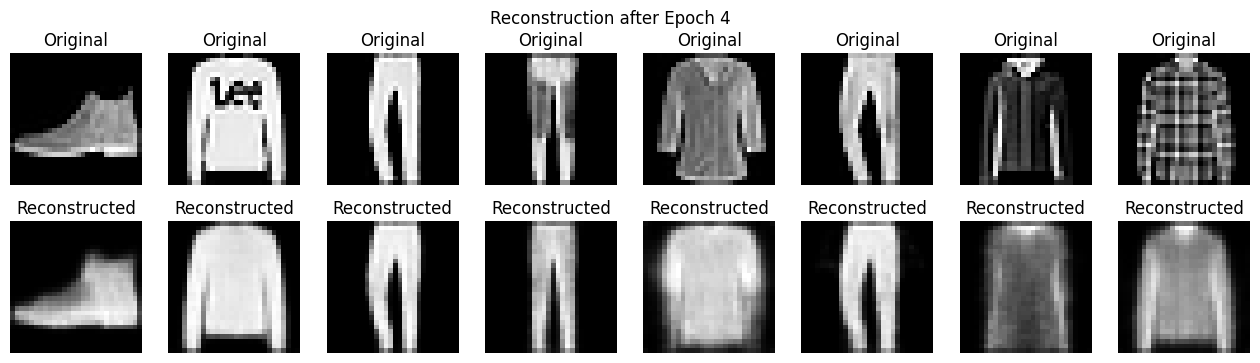

Epoch [5/10], Train Loss: 24.1222, Val Loss: 24.2205


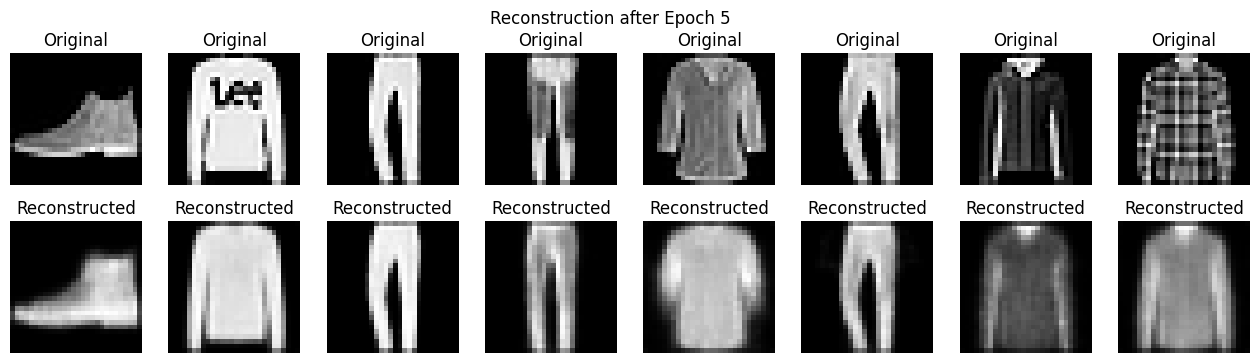

Epoch [6/10], Train Loss: 23.9172, Val Loss: 24.0539


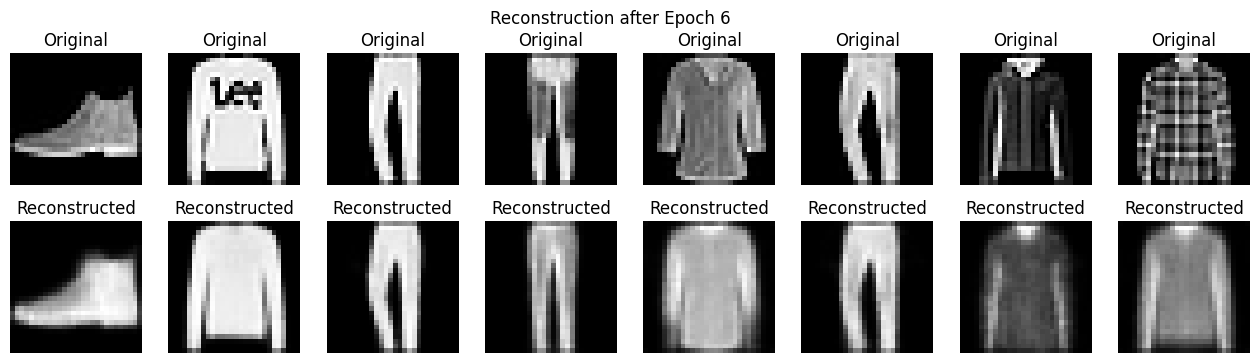

Epoch [7/10], Train Loss: 23.7869, Val Loss: 23.7415


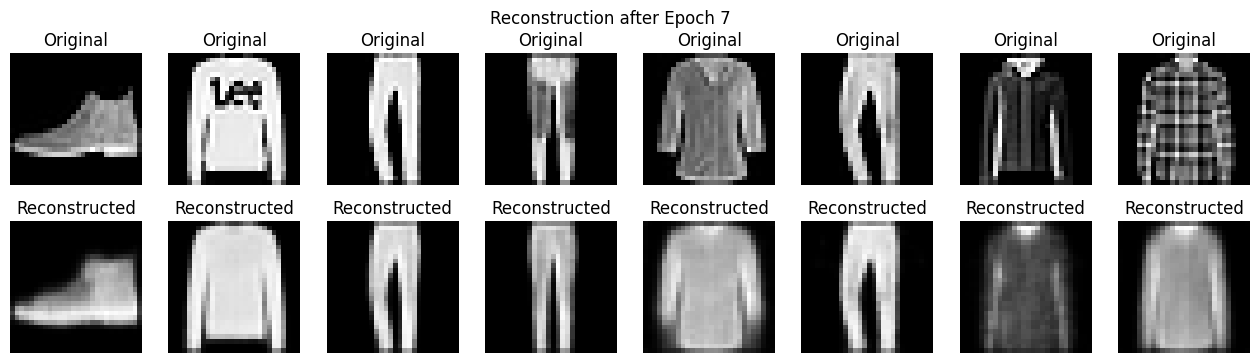

Epoch [8/10], Train Loss: 23.6517, Val Loss: 23.7216


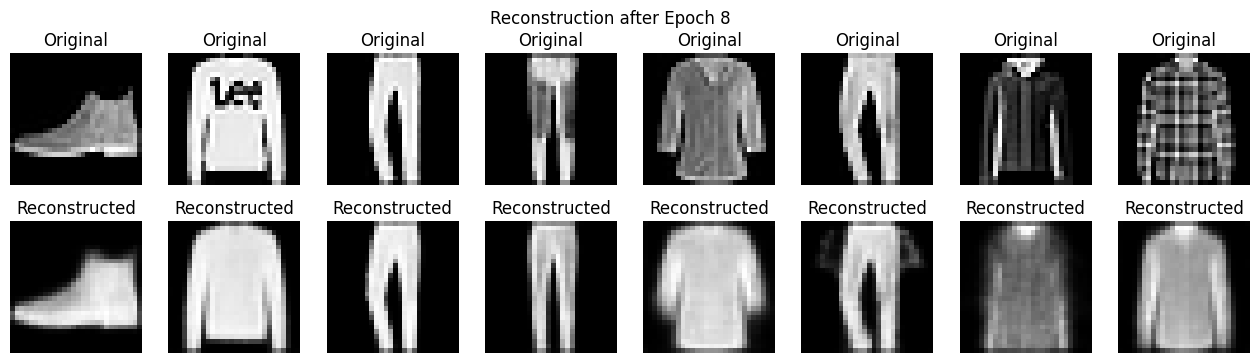

Epoch [9/10], Train Loss: 23.5428, Val Loss: 23.6030


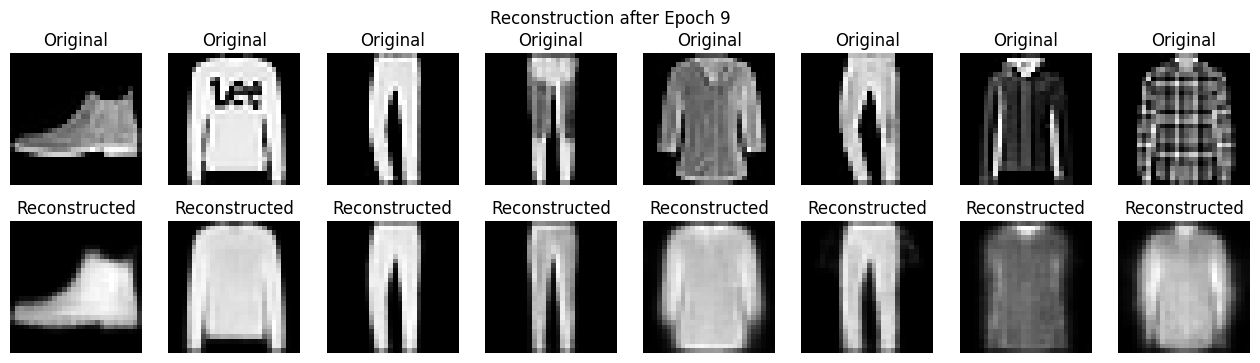

Epoch [10/10], Train Loss: 23.4708, Val Loss: 23.4889


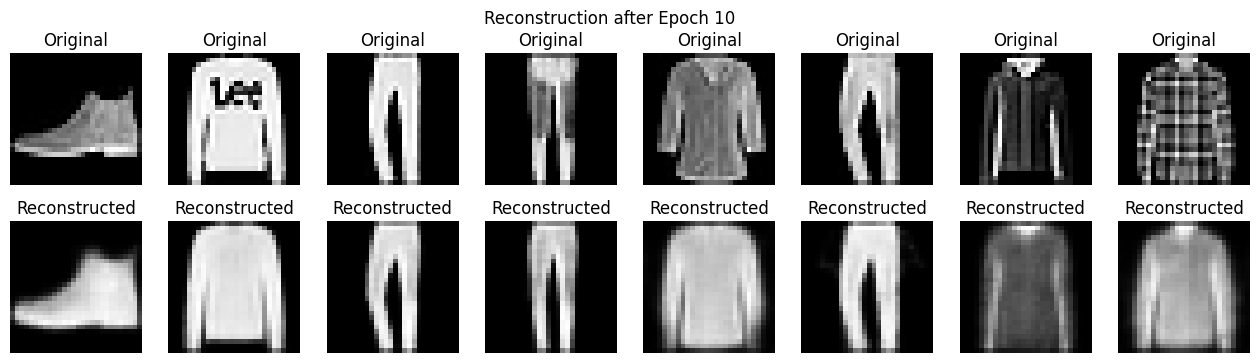

In [35]:
# Get a fixed batch of test images for consistent reconstruction visualization
fixed_images, _ = next(iter(test_loader))
fixed_images = fixed_images.to(device)

# Instantiate model and optimizer
latent_dim = 20
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon_images, mu, logvar = model(images)
            loss = vae_loss(recon_images, images, mu, logvar)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # === Visualization of reconstructions ===
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(fixed_images)

    n = 8  # Number of images to show
    plt.figure(figsize=(16, 4))

    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(fixed_images[i].squeeze().cpu(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze().cpu(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.suptitle(f"Reconstruction after Epoch {epoch + 1}")
    plt.show()



<span style="color: MediumPurple;"> (d) Record the training and validation losses.
</span>

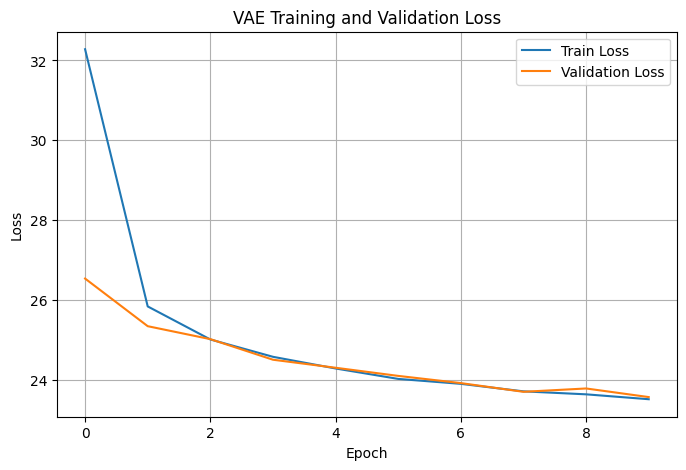

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('VAE Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### <span style="color: HotPink;"> 2. Visualize Reconstructions and Generations
</span>

<span style="color: MediumPurple;"> (a) Visualize reconstructions from the encoder-decoder pipeline for several test examples.
</span>

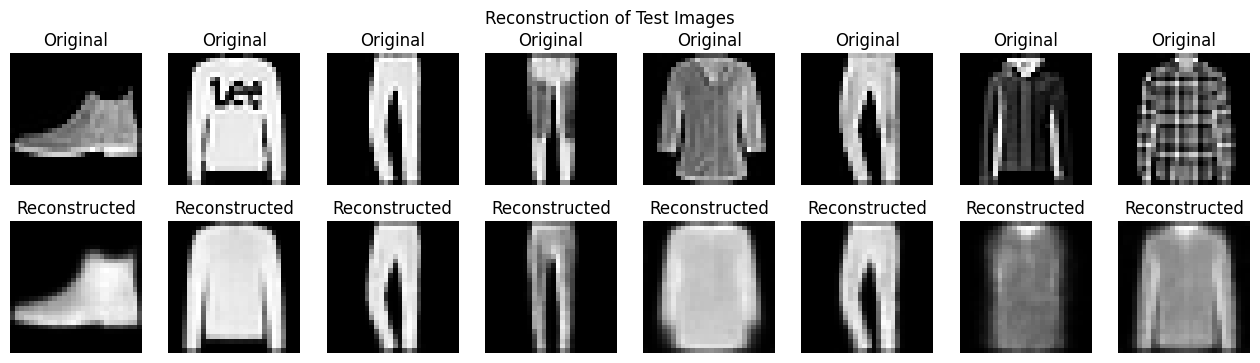

In [11]:
# 2(a) - Visualize reconstructions from encoder-decoder pipeline
model.eval()
with torch.no_grad():
    sample_images, _ = next(iter(test_loader))
    sample_images = sample_images.to(device)
    recon_images, _, _ = model(sample_images)

n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Reconstruction of Test Images")
plt.show()


<span style="color: MediumPurple;"> (b) Visualize generations by sampling z ∼p(z) and decoding to image space.
</span>

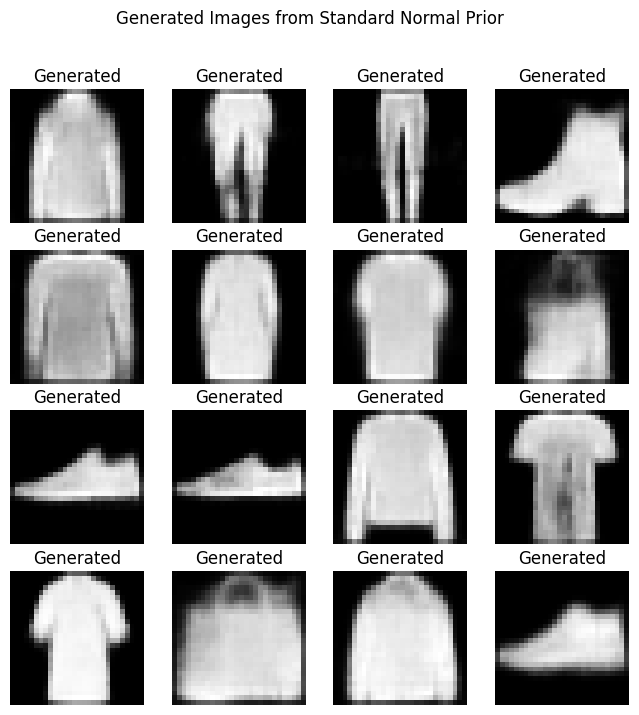

In [12]:
# 2(b) - Generation from standard normal prior
model.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)  # sample from N(0, I)
    generated_images = model.decode(z)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Generated")
    plt.axis('off')

plt.suptitle("Generated Images from Standard Normal Prior")
plt.show()


<span style="color: MediumPurple;"> (c) Try generating samples from a different prior distribution (e.g., Laplacian) and compare.
</span>

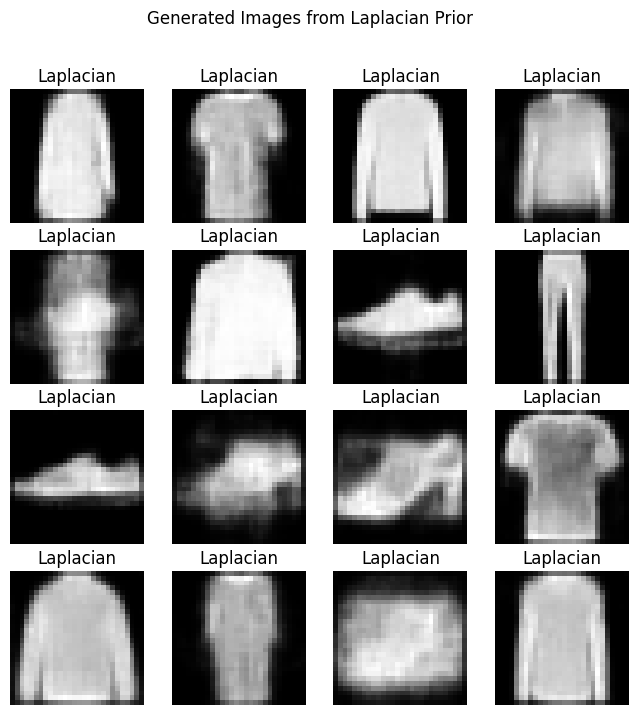

In [13]:
# 2(c) - Generation from Laplacian prior
model.eval()
with torch.no_grad():
    # Laplace distribution: loc=0, scale=1
    laplace_dist = torch.distributions.Laplace(loc=0.0, scale=1.0)
    z_laplace = laplace_dist.sample((16, latent_dim)).to(device)
    generated_laplace = model.decode(z_laplace)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_laplace[i].squeeze().cpu(), cmap='gray')
    plt.title("Laplacian")
    plt.axis('off')

plt.suptitle("Generated Images from Laplacian Prior")
plt.show()


<span style="color: #D8BFD8;"> side by side comparison
</span>

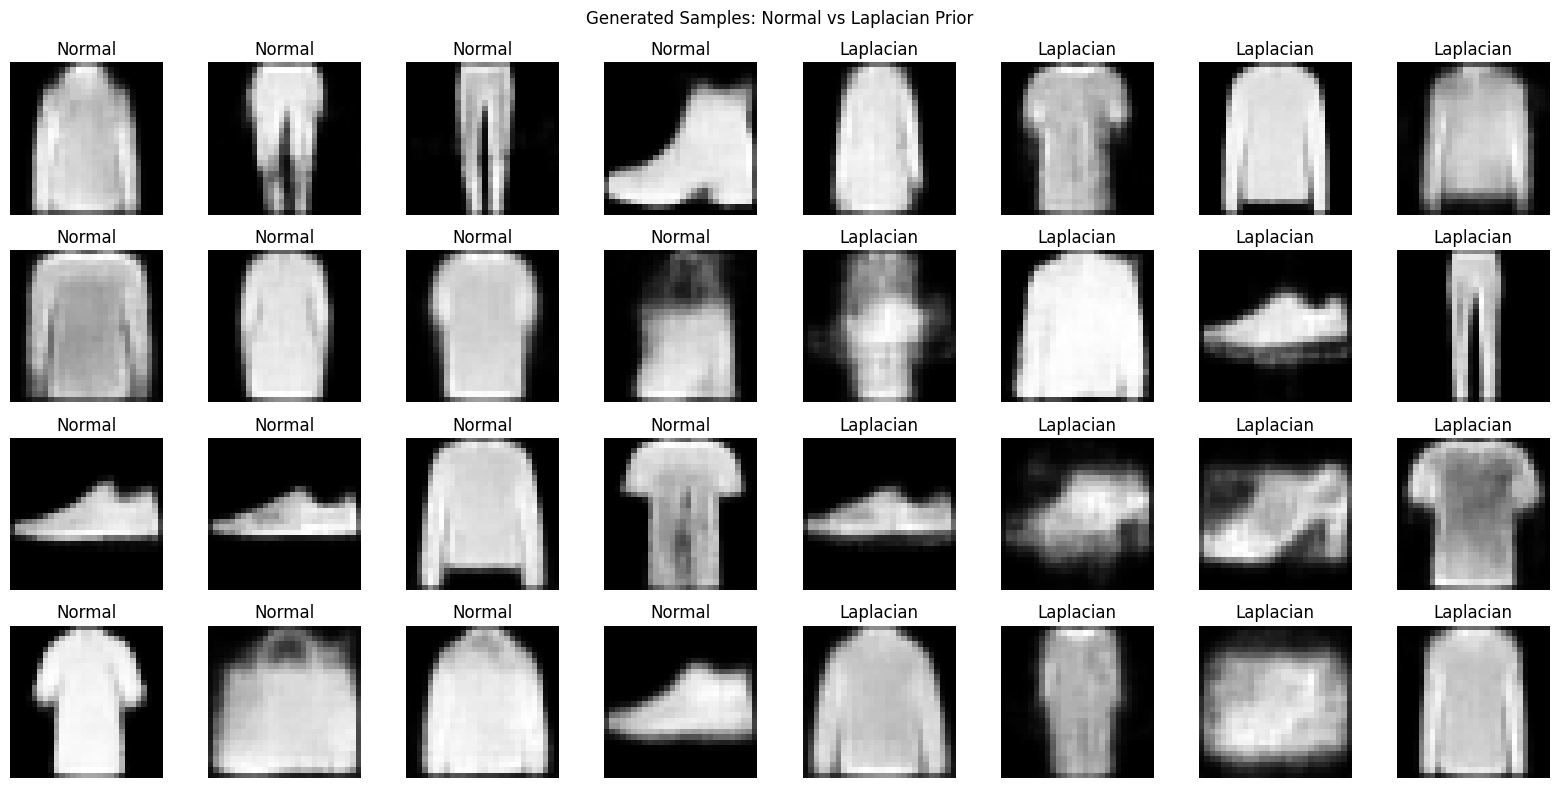

In [14]:
# Side-by-side comparison
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i in range(16):
    # Normal
    axes[i // 4, i % 4].imshow(generated_images[i].squeeze().cpu(), cmap='gray')
    axes[i // 4, i % 4].set_title("Normal")
    axes[i // 4, i % 4].axis('off')

    # Laplacian
    axes[i // 4, i % 4 + 4].imshow(generated_laplace[i].squeeze().cpu(), cmap='gray')
    axes[i // 4, i % 4 + 4].set_title("Laplacian")
    axes[i // 4, i % 4 + 4].axis('off')

plt.suptitle("Generated Samples: Normal vs Laplacian Prior")
plt.tight_layout()
plt.show()


<span style="color: MediumPurple;"> (d) Document these samples in your report and describe any observations or differences between reconstructions and generations.
</span>

### <span style="color: HotPink;"> 3. Posterior Collapse Investigation
</span>

<span style="color: MediumPurple;"> (a) Examine your reconstructions and generations carefully. You should notice that even though your loss is decreasing, the generated samples may look very similar or form a uniform “blob.”
</span>

<span style="color: MediumPurple;"> (b) Analyze the ELBO components: reconstruction loss and KL divergence.
</span>

<span style="color: MediumPurple;"> (c) Confirm whether your posterior qφ(z|x) is collapsing (i.e., the encoder outputs are ignoring the input and matching the prior too closely).
</span>

<span style="color: MediumPurple;"> (d) Think about why and under what circumstances posterior collapse happens in VAEs. Consider:</span>   

<span style="color: MediumPurple;">1. The relative power of the encoder and decoder.</span>   

<span style="color: MediumPurple;">2. The effect of the KL term early in training</span>   

### <span style="color: HotPink;"> 4. Mitigating Posterior Collapse
</span>

<span style="color: MediumPurple;"> (a) Design and implement a strategy to prevent posterior collapse without modifying the model architecture.
</span>

<span style="color: MediumPurple;"> (b) Hint: you might want to give the encoder a chance to learn meaningful representations before the KL
term is fully enforced. Consider adjusting learning rates, training the encoder more aggressively, or
gradually introducing the KL term.
</span>

<span style="color: MediumPurple;"> (c) Compare results of reconstruction and generations with your strategy and explain briefly why your
strategy works.
</span>